# Merge CTD and satellite data extracted at observation locations
Created by Ivan Lima on Tue Nov  2 2021 14:42:35 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Nov  9 09:37:59 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Read satellite & CTD data

In [3]:
df_sat = pd.read_csv('data/metadata_2012topresent_satellite.csv', index_col=0)
df_sat['Date'] = pd.to_datetime(df_sat[['Year','Month','Day']])

# df_ctd = pd.read_csv('data/modelledmoderncarbchem.csv', index_col=0)
# df_ctd['Date'] = pd.to_datetime(df_ctd[['Year','Month','Day']])

df_ctd = pd.read_hdf('data/modelledmoderncarbchem.h5', key='df_ctd')

## Do inner join 

In [4]:
# sat_cols = ['Cast', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Date', 'ADT',
#             'UGOS', 'VGOS', 'SLA', 'UGOSA', 'VGOSA', 'SST', 'SST_hires', 'Chl', 'KD490']

# ctd_cols = ['X', 'Cast', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Date', 'Depth', 'Temperature', 'Salinity',
#             'Dissolved.oxygen', 'Pressure', 'pCO2_yearave', 'pCO2_monthave', 'Lat', 'Long', 'bottom_depth',
#             'lat', 'long', 'Oxygen', 'OmegaA','OmegaC', 'CO3', 'fCO2', 'pCO2', 'pH', 'HCO3']

sat_cols = ['Cast', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Date',
            'SLA', 'SST', 'SST_hires', 'Chl', 'KD490']

ctd_cols = ['X', 'Cast', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Date', 'Depth', 'Temperature', 'Salinity',
            'Dissolved.oxygen', 'Pressure', 'pCO2_yearave', 'pCO2_monthave', 'bottom_depth', 'Oxygen']

df_merged = pd.merge(df_ctd[ctd_cols], df_sat[sat_cols], on=['Date','Latitude','Longitude'],
                     how='inner', suffixes=['_ctd', '_sat'])

print('Original data: {} rows'.format(len(df_ctd)))
print('New merged data: {} rows'.format(len(df_merged)))
print('Difference: {} rows'.format(len(df_merged)-len(df_ctd)))

Original data: 1351922 rows
New merged data: 1401475 rows
Difference: 49553 rows


## Check if records match for merged variables 

In [5]:
def check(vname):
    vname_ctd, vname_sat = vname+'_ctd', vname+'_sat'
    df_work = df_merged[[vname_ctd, vname_sat]].dropna()
    if len(df_work) == (df_work[vname_ctd]==df_work[vname_sat]).sum():
        print('{}: OK'.format(vname))
    else:
        n = len(df_work) - (df_work[vname_ctd]==df_work[vname_sat]).sum()
        print('{}: {} records do not match'.format(vname, n))

varcols = [c[:-4] for c in df_merged.columns if c.endswith('_ctd')]
for vname in varcols:
    check(vname)

Cast: 49553 records do not match
Year: OK
Month: OK
Day: OK


**Note:** The number of extra rows in the new merged data set is the same as the number of records for which *Cast* does not match in the CTD and merged data sets. So Louise probably removed the records for which *Cast* does not match. So we only use records where *Cast* matches.

In [6]:
df_ctd_sat = df_merged[df_merged['Cast_ctd']==df_merged['Cast_sat']]

## Plot satelitte data for original and new dataset

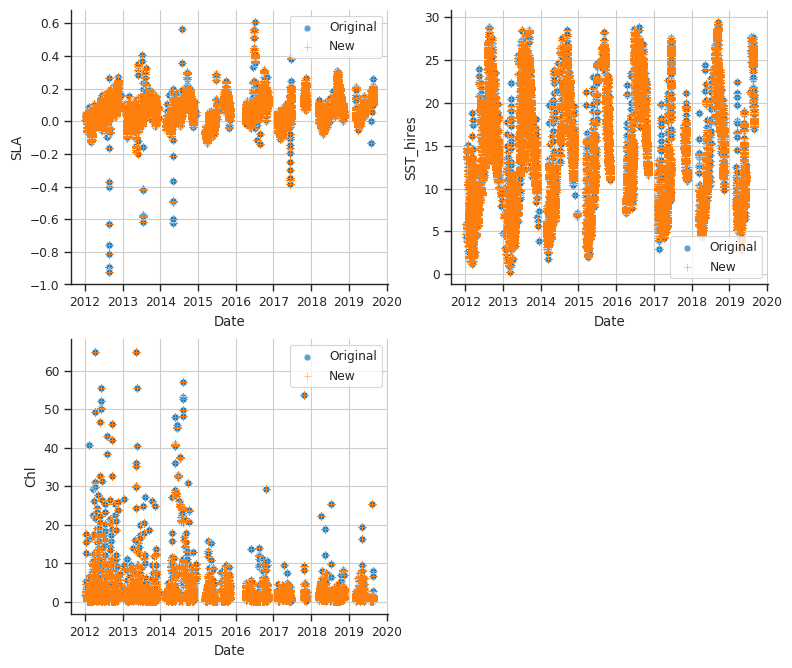

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
fig.delaxes(axs[1,1])
for ax, vname in zip(axs.ravel(),['SLA','SST_hires','Chl']):
    _ = sns.scatterplot(x='Date', y=vname, data=df_ctd, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Date', y=vname, data=df_ctd_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

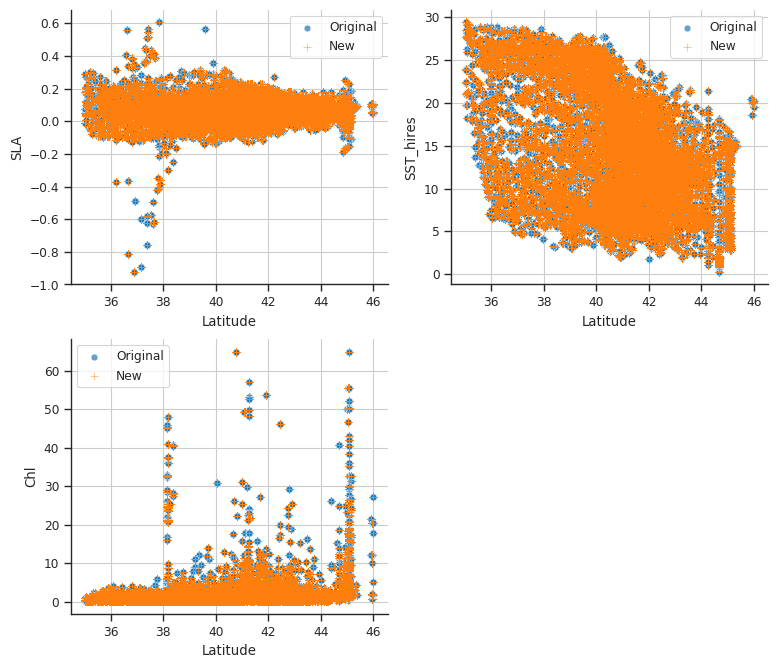

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
fig.delaxes(axs[1,1])
for ax, vname in zip(axs.ravel(),['SLA','SST_hires','Chl']):
    _ = sns.scatterplot(x='Latitude', y=vname, data=df_ctd, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Latitude', y=vname, data=df_ctd_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

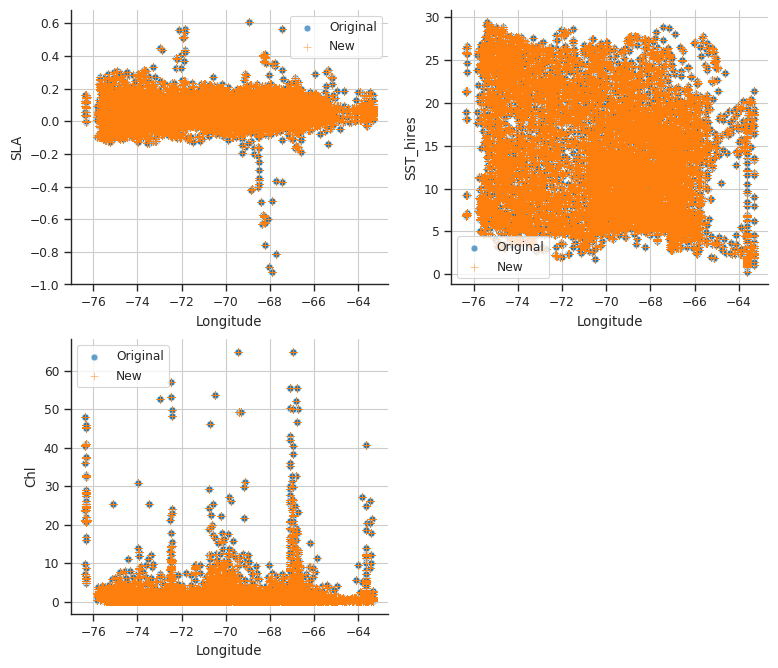

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
fig.delaxes(axs[1,1])
for ax, vname in zip(axs.ravel(),['SLA','SST_hires','Chl']):
    _ = sns.scatterplot(x='Longitude', y=vname, data=df_ctd, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Longitude', y=vname, data=df_ctd_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

## Compare original and new data sets 

The two data sets are the same except for differences in precision for the satellite variables.

In [10]:
labels = ['Cast_ctd', 'Cast_sat', 'Year_ctd', 'Month_ctd', 'Day_ctd', 'Year_sat', 'Month_sat', 'Day_sat',
          'SST', 'KD490']
df_new = df_ctd_sat.drop(labels=labels,axis=1)
df_new = df_new.sort_values(by=['Date','Latitude','Longitude']).reset_index(drop=True)

df_old = df_ctd[df_new.columns].sort_values(by=['Date','Latitude','Longitude']).reset_index(drop=True)

# Print difference between each variable in the two data sets
def check_diff(vname):
    diff = df_new[vname] - df_old[vname]
    print('{}: {}, {}'.format(vname, diff.min(), diff.max()))

for vname in ['X', 'Latitude', 'Longitude', 'Depth', 'Temperature', 'Salinity', 'Dissolved.oxygen', 'Pressure',
              'pCO2_yearave', 'pCO2_monthave', 'bottom_depth', 'Oxygen', 'SLA', 'SST_hires', 'Chl']:
    check_diff(vname)

X: 0, 0
Latitude: 0.0, 0.0
Longitude: 0.0, 0.0
Depth: 0.0, 0.0
Temperature: 0.0, 0.0
Salinity: 0.0, 0.0
Dissolved.oxygen: 0.0, 0.0
Pressure: 0.0, 0.0
pCO2_yearave: 0.0, 0.0
pCO2_monthave: 0.0, 0.0
bottom_depth: 0, 0
Oxygen: 0.0, 0.0
SLA: -5.273559366969494e-16, 5.134781488891349e-16
SST_hires: -5.3290705182007514e-14, 4.973799150320701e-14
Chl: -4.973799150320701e-14, 4.973799150320701e-14


**Note:** The test below fails because of differences in precision between the two data sets.

In [11]:
df_new.equals(df_old)

False

## Save merged data set to HDF file 

In [13]:
df_ctd_sat_final = df_ctd_sat.drop(['Cast_sat','Year_sat','Month_sat','Day_sat'], axis=1).rename(columns={'Cast_ctd':'Cast',
                                                                                                          'Year_ctd':'Year',
                                                                                                          'Month_ctd':'Month',
                                                                                                          'Day_ctd':'Day'})
df_ctd_sat_final.to_hdf('data/ctd_satellite_data.h5', key='df_ctd_sat', mode='w', complevel=9)